## **Implement Advanced ML Algorithm for Classification**
**Dataset from BlackBoard:** Facial Emotion Recognition dataset

**File:** facial-emotion-recognition.zip (432.768 MB)

### **ToDo**
- Hyperparameter tuning
- Used proper loss/metrics standard in image classification, from sklearm.metrics
- Comparability: use same imported metric on all algorithms
- Explain model: google/vit-base-patch16-224-in21k
- Here we interpret term advanced according to lecture slides, which focus on knowledge transfer.
- In modern image classification goes without required pre-processing, thus skipped here. Traditional models do require manual crafted feature enginnering, while one of the key properties of ANN-based, feature engineering is inherent within the model as input data is transformed between hidden layers.
- Explain the code
- There are many base models to select from, here we selected visual transformer (ViT) as these are considered SOTA.
- https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html



@misc{wu2020visual,
      title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, 
      author={Bichen Wu and Chenfeng Xu and Xiaoliang Dai and Alvin Wan and Peizhao Zhang and Zhicheng Yan and Masayoshi Tomizuka and Joseph Gonzalez and Kurt Keutzer and Peter Vajda},
      year={2020},
      eprint={2006.03677},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch import nn, optim
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import time
import copy
import os

---
## **Vision Transformer (ViT) Model Pre-Trained on ImageNet-21k**
---

Classes found in the dataset:
0: buildings
1: forest
2: glacier
3: mountain
4: sea
5: street


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/cluster/home/thohau/.conda/envs/AI/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Training dataset size: 11227 samples
Validation dataset size: 2807 samples
Using device: cuda
-------- START TRAINING -----------
Epoch [1/25], Train Loss: 1.1418, Train Accuracy: 80.06%
Epoch [1/25], Val Loss: 0.6169, Val Accuracy: 92.55%
Epoch [2/25], Train Loss: 0.4615, Train Accuracy: 92.85%
Epoch [2/25], Val Loss: 0.3549, Val Accuracy: 94.58%
Epoch [3/25], Train Loss: 0.3130, Train Accuracy: 94.60%
Epoch [3/25], Val Loss: 0.2892, Val Accuracy: 94.66%
Epoch [4/25], Train Loss: 0.2512, Train Accuracy: 95.55%
Epoch [4/25], Val Loss: 0.2515, Val Accuracy: 94.73%
Epoch [5/25], Train Loss: 0.2059, Train Accuracy: 96.67%
Epoch [5/25], Val Loss: 0.2452, Val Accuracy: 94.26%
Epoch [6/25], Train Loss: 0.1709, Train Accuracy: 97.51%
Epoch [6/25], Val Loss: 0.2204, Val Accuracy: 94.55%
Epoch [7/25], Train Loss: 0.1460, Train Accuracy: 97.83%
Epoch [7/25], Val Loss: 0.2189, Val Accuracy: 94.55%
Epoch [8/25], Train Loss: 0.1221, Train Accuracy: 98.42%
Epoch [8/25], Val Loss: 0.2313, Val Accura

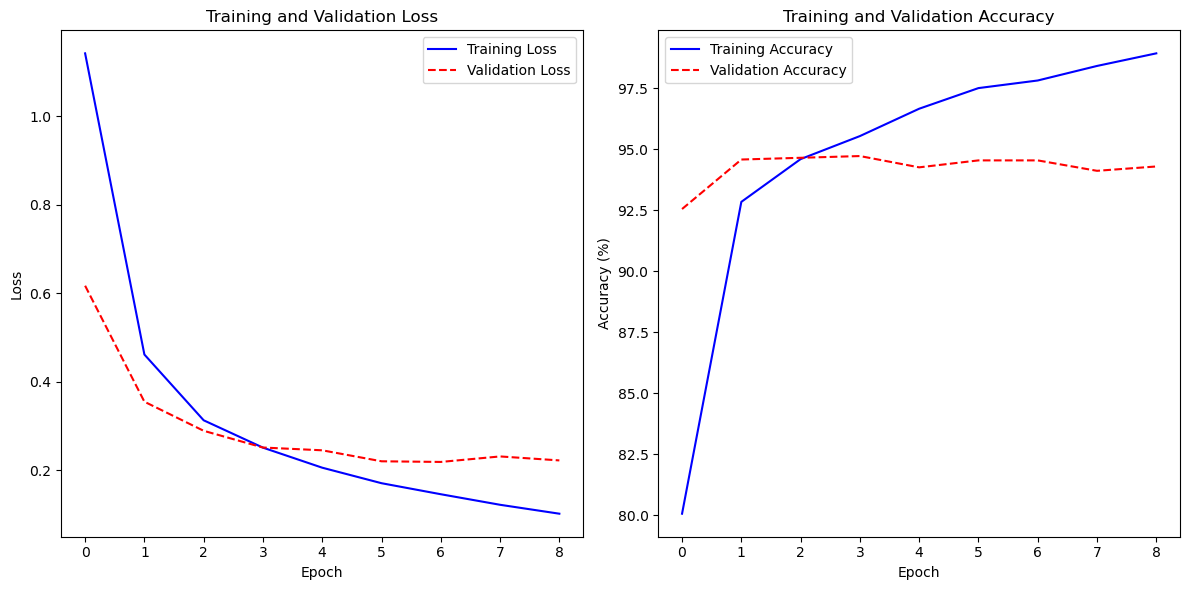

In [2]:
# Step 1: Define the path to your local dataset
dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_train/seg_train/"
model_path_vit = "/cluster/work/thohau/IT3212/assignment_4/thomas/models/vit_it3212_gr25.pth"
save_model = True

# Step 2: Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ViT
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet standard normalization
]))

# Ensure that we correctly detect the classes from the subfolders
class_names = full_dataset.classes  # List of class names (subfolder names under dataset_path)
print("Classes found in the dataset:")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

# Step 3: Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Step 4: Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"  # You can try other models too
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(class_names))  # Use len(class_names) for num_labels
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Step 5: Set up DataLoader for training and validation
BACTH_SIZE = 90
MAX_EPOCHS = 25
EARLY_STOP = 5
train_dataloader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BACTH_SIZE, shuffle=False)

# Step 6: Print the size of training and validation datasets
print(f"\nTraining dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")

# Step 7: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Step 8: Fine-tuning the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the device being used
print(f"Using device: {device}")

# Variables to track loss and accuracy
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

print(f"-------- START TRAINING -----------")

# Early stopping variables
best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
best_val_acc = 0.0
epoch_no_improvement = 0

# Training loop
start_time = time.time()
for epoch in range(MAX_EPOCHS):
    
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    # Training loop
    for batch in train_dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(train_dataloader)
    accuracy = 100 * correct_predictions / total_predictions

    train_loss_history.append(avg_loss)
    train_acc_history.append(accuracy)

    print(f"Epoch [{epoch+1}/{MAX_EPOCHS}], Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

    # Step 9: Evaluate on Validation Set
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.logits, labels)

            val_running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.logits, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

    # Calculate average validation loss and accuracy
    val_avg_loss = val_running_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions

    val_loss_history.append(val_avg_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{MAX_EPOCHS}], Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Check for early stopping
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model
        epoch_no_improvement = 0  # Reset counter for no improvement
    else:
        epoch_no_improvement += 1

    # Early stopping condition
    if epoch_no_improvement >= EARLY_STOP:
        print(f"Early stopping triggered after {epoch_no_improvement} epochs with no improvement.")
        break

time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')

# Step 10: Save the best model
if save_model:
    print(f"Saving the best model to {model_path_vit}")
    torch.save(best_model_wts, model_path_vit)  # Save the best model weights

# Step 11: Plot Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

Model size: 327.39 MB
Total number of parameters: 23520326
Test dataset size: 3000 samples
Test Accuracy: 0.9343

Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.94       437
      forest       0.99      1.00      0.99       474
     glacier       0.90      0.87      0.89       553
    mountain       0.88      0.89      0.89       525
         sea       0.95      0.98      0.96       510
      street       0.94      0.95      0.95       501

    accuracy                           0.93      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.93      0.93      0.93      3000



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9406626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


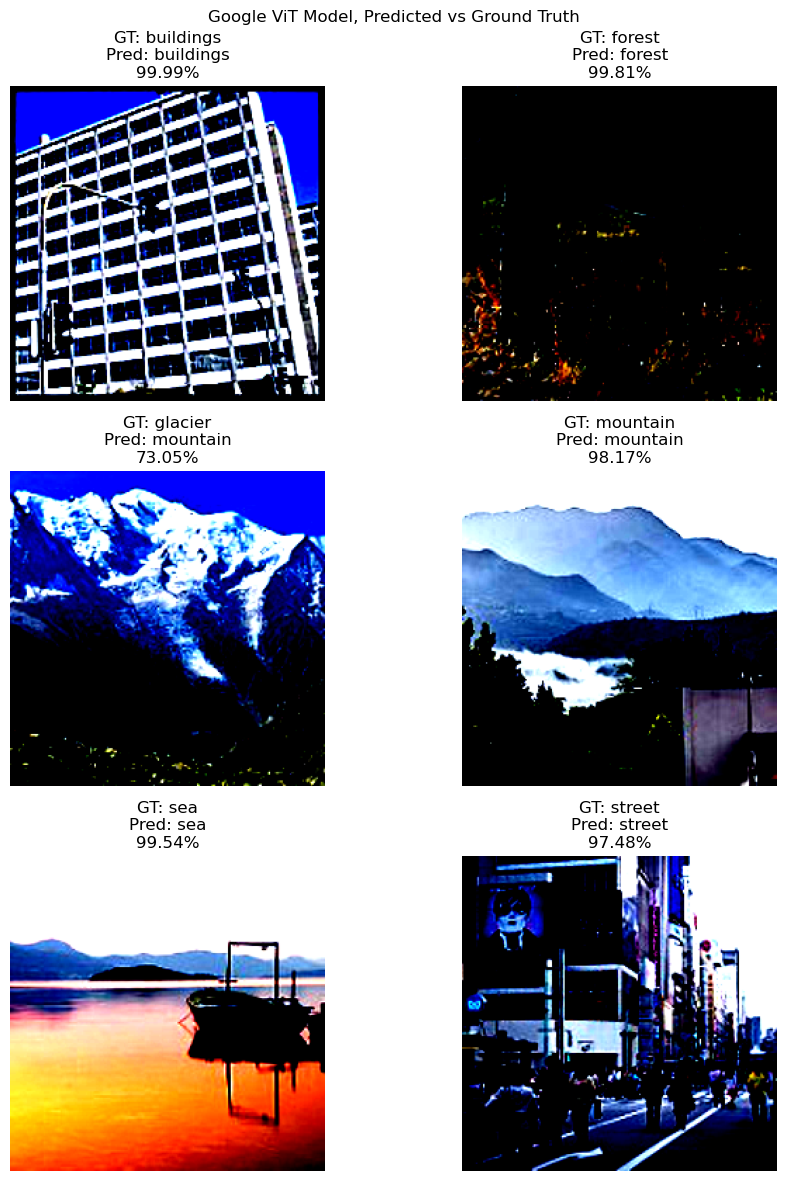

In [13]:
# Print size of the model in MB
dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_train/seg_train/"
model_path_vit = "/cluster/work/thohau/IT3212/assignment_4/thomas/models/vit_it3212_gr25.pth"

model_size = os.path.getsize(model_path_vit) / (1024 * 1024)  # Convert bytes to MB
print(f"Model size: {model_size:.2f} MB")

# Count the number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

model = model.to(device)
# Load the test dataset (replace with your actual test dataset path)
test_dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_test/seg_test/"  # Replace this with the actual path to your dataset

test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ResNet
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
]))

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print the size of the test dataset
print(f"Test dataset size: {len(test_dataset)} samples")


# Function to evaluate the model on the test set
def evaluate_model_on_test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            # Extract logits (assuming output has a .logits attribute)
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Hugging Face models typically return a tuple where logits are the first element
            elif hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs

            preds = torch.argmax(logits, dim=1)  # Get predicted class labels

            running_corrects += torch.sum(preds == labels.data)

            predictions.extend(preds.cpu().numpy())  # Store predictions
            true_labels.extend(labels.cpu().numpy())  # Store true labels

    # Calculate accuracy
    accuracy = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Generate and print the classification report

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=test_dataset.classes))
    
# Final evaluation on the test dataset
evaluate_model_on_test(model, test_loader)

def plot_random_images_with_predictions(model, test_dataset, num_images=6):
    # Ensure that we sample one image per class
    class_indices = {i: [] for i in range(len(test_dataset.classes))}
    
    # Collect image indices for each class
    for idx, (_, label) in enumerate(test_dataset):
        class_indices[label].append(idx)
    
    # Sample one image from each class
    sampled_indices = []
    for class_id in range(len(test_dataset.classes)):
        sampled_indices.append(random.choice(class_indices[class_id]))  # Randomly sample one image per class
    
    # Adjust the figure size to better fit the 3x2 layout
    plt.figure(figsize=(10, 12))  # Adjusted size for a 3x2 grid
    plt.suptitle('Google ViT Model, Predicted vs Ground Truth')

    for i, idx in enumerate(sampled_indices):
        image, true_label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get prediction
        with torch.no_grad():
            outputs = model(image)
            # Extract logits from ImageClassifierOutput (if it's the output format)
            if isinstance(outputs, tuple):  # If it's a tuple (e.g., from Hugging Face models)
                logits = outputs[0]  # Logits are usually the first element
            elif hasattr(outputs, 'logits'):  # If it's an ImageClassifierOutput object
                logits = outputs.logits
            else:  # If it's just a tensor (standard PyTorch model output)
                logits = outputs
            _, preds = torch.max(logits, 1)
            pred_label = preds.item()
            confidence = torch.softmax(logits, dim=1)[0, preds].item() * 100  # Confidence in percentage

        # Plot the image
        plt.subplot(3, 2, i + 1)
        plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0))  # Remove batch dimension and permute to HWC
        plt.axis('off')

        # Get class names
        true_class = test_dataset.classes[true_label]
        pred_class = test_dataset.classes[pred_label]

        # Title with Ground Truth, Predicted Class, and Confidence
        plt.title(f"GT: {true_class}\nPred: {pred_class}\n{confidence:.2f}%")

    plt.tight_layout()
    plt.show()


# Plot random images with predictions (one from each category)
plot_random_images_with_predictions(model, test_dataset)

---
## **ResNet-50**
---

Classes found in the dataset:
0: buildings
1: forest
2: glacier
3: mountain
4: sea
5: street

Training dataset size: 11227 samples
Validation dataset size: 2807 samples

Example images and labels from the dataset:
Image 0: Label = buildings
Image 1: Label = buildings
Image 2: Label = buildings
Image 3: Label = buildings
Image 4: Label = buildings


/cluster/home/thohau/.conda/envs/AI/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/thohau/.conda/envs/AI/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
-------- START - Adapt ResNet-50 to Intel Dataset -----------
Epoch [0/9]
----------
train Loss: 0.5022 Acc: 0.8515
val Loss: 0.2279 Acc: 0.9234
Epoch [1/9]
----------
train Loss: 0.2117 Acc: 0.9261
val Loss: 0.2109 Acc: 0.9195
Epoch [2/9]
----------
train Loss: 0.1707 Acc: 0.9423
val Loss: 0.1973 Acc: 0.9312
Epoch [3/9]
----------
train Loss: 0.1346 Acc: 0.9555
val Loss: 0.1918 Acc: 0.9327
Epoch [4/9]
----------
train Loss: 0.1077 Acc: 0.9654
val Loss: 0.1928 Acc: 0.9323
Epoch [5/9]
----------
train Loss: 0.0815 Acc: 0.9751
val Loss: 0.1985 Acc: 0.9334
Epoch [6/9]
----------
train Loss: 0.0596 Acc: 0.9841
val Loss: 0.2059 Acc: 0.9320
Epoch [7/9]
----------
train Loss: 0.0472 Acc: 0.9883
val Loss: 0.2077 Acc: 0.9291
Epoch [8/9]
----------
train Loss: 0.0333 Acc: 0.9931
val Loss: 0.2280 Acc: 0.9330
Early stopping after 5 epochs with no improvement.
Epoch [9/9]
----------
train Loss: 0.1093 Acc: 0.9643
val Loss: 0.1885 Acc: 0.9312
Training complete in 8.0m 10.513791799

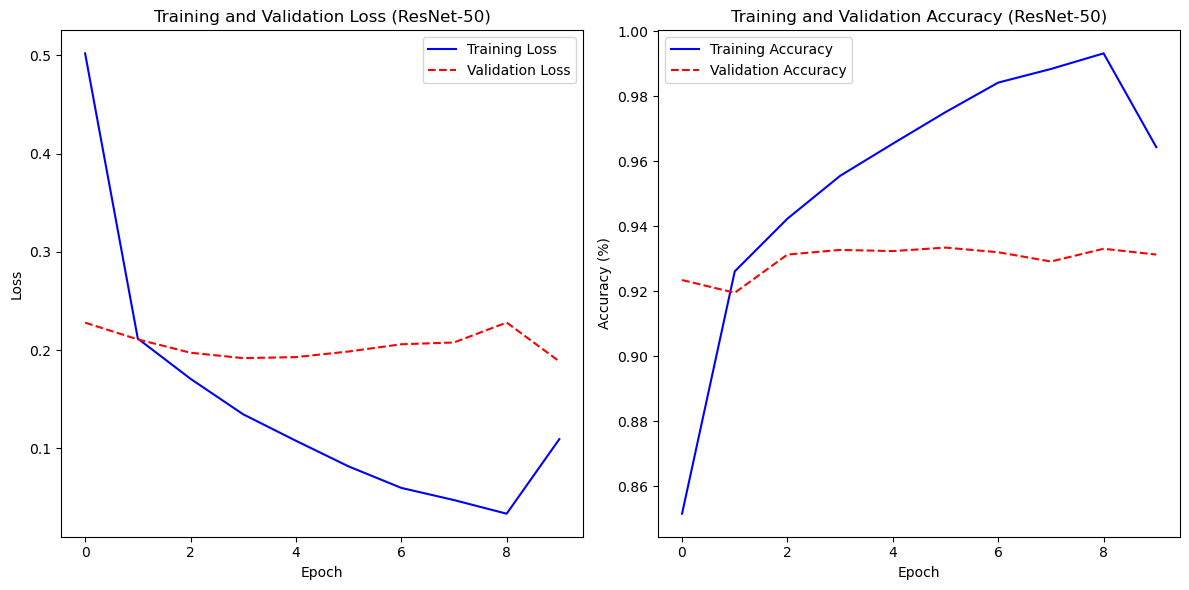

In [10]:
# Step 1: Define the path to your local dataset
#dataset_path = "/Users/thomas/Desktop/IT3212/assignment_4/thomas/intel-image-classification/seg_train/seg_train/"  # Replace this with the actual path to your dataset
dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_train/seg_train/"  # Replace this with the actual path to your dataset
model_path_resnet = "/cluster/work/thohau/IT3212/assignment_4/thomas/models/resnet_it3212_gr25.pth"

# Step 1: Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ViT
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet standard normalization
]))

# Ensure that we correctly detect the classes from the subfolders
class_names = full_dataset.classes  # List of class names (subfolder names under dataset_path)
print("Classes found in the dataset:")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

# Step 2: Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


# Step 4: Set up DataLoader for training and validation
BACTH_SIZE = 64
MAX_EPOCHS = 25
EARLY_STOP = 5
train_loader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BACTH_SIZE, shuffle=False)

# Step 5: Print the size of training and validation datasets
print(f"\nTraining dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")

# Step 6: Print a few examples from the dataset to verify the structure
print("\nExample images and labels from the dataset:")
for i in range(5):
    image, label = full_dataset[i]  # Access the first 5 samples
    print(f"Image {i}: Label = {class_names[label]}")  # Print class name for label


# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze the parameters in the pre-trained model (optional)
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Modify output layer to match the number of classes

# If you want to fine-tune the whole model, you can unfreeze the last few layers
# Unfreeze the last block
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Define Loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler (optional, helps with fine-tuning)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Variables to track loss and accuracy
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

print(f"-------- START - Adapt ResNet-50 to Intel Dataset -----------")
# Function to train the model with Early Stopping
def train_model(model,
                criterion,
                optimizer,
                num_epochs=MAX_EPOCHS,
                patience=EARLY_STOP,
                save_model=False, 
                model_save_path="best_model.pth"):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
    best_acc = 0.0
    best_loss = float('inf')  # Initialize best_loss as a very large number
    epoch_no_improvement = 0  # Count of consecutive epochs with no improvement
    
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch}/{num_epochs - 1}]')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            dataloaders = train_loader if phase == 'train' else val_loader
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward Pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders.dataset)
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save loss and accuracy in history lists
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())  # Convert to a scalar value
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())  # Convert to a scalar value

            # Early Stopping Logic: Check if validation loss improved
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    # If validation loss improved, reset the counter and save the model
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epoch_no_improvement = 0  # Reset the no-improvement counter
                else:
                    epoch_no_improvement += 1

                # Stop training if no improvement for 'patience' epochs
                if epoch_no_improvement >= patience:
                    print(f"Early stopping after {patience} epochs with no improvement.")
                    model.load_state_dict(best_model_wts)  # Restore best model
              
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # Load best model weights in case of early stopping
    model.load_state_dict(best_model_wts)
    
    # Save model if specified
    if save_model:
        print(f"Saving model to {model_save_path}")
        torch.save(model.state_dict(), model_save_path)

    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=10, save_model=True, model_save_path=model_path_resnet)

# Plot Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ResNet-50)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (ResNet-50)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

Using device: cuda


/cluster/home/thohau/.conda/envs/AI/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1779690/3971815292.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization

Model size: 90.03 MB
Total number of parameters: 23520326
Test dataset size: 3000 samples
Test Accuracy: 0.9343

Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.94       437
      forest       0.99      1.00      0.99       474
     glacier       0.90      0.87      0.89       553
    mountain       0.88      0.89      0.89       525
         sea       0.95      0.98      0.96       510
      street       0.94      0.95      0.95       501

    accuracy                           0.93      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.93      0.93      0.93      3000



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6998693..2.2885156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


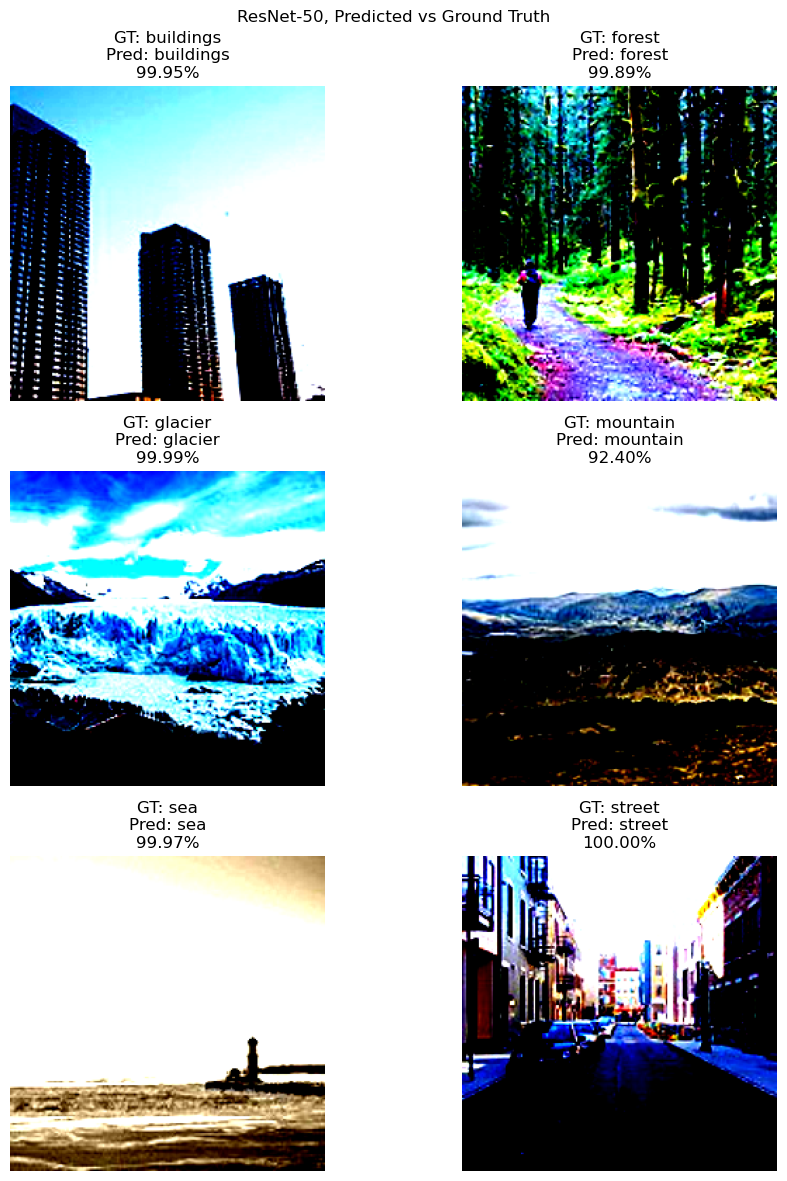

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained model (ResNet50)
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 6)  # Modify the final layer for 6 output classes

# Load the saved model state dictionary
model_path_rsnet = '/cluster/work/thohau/IT3212/assignment_4/thomas/models/resnet_it3212_gr25.pth'
state_dict = torch.load(model_path_rsnet, map_location=device)

# Load the state dict into the model
model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore the mismatch in fc layer

# Print size of the model in MB
model_size = os.path.getsize(model_path_rsnet) / (1024 * 1024)  # Convert bytes to MB
print(f"Model size: {model_size:.2f} MB")

# Count the number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")



# Load the test dataset (replace with your actual test dataset path)
test_dataset_path = dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_test/seg_test/"  # Replace this with the actual path to your dataset

test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ResNet
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
]))

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print the size of the test dataset
print(f"Test dataset size: {len(test_dataset)} samples")

# Function to evaluate the model on the test set
def evaluate_model_on_test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model = model.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class labels

            running_corrects += torch.sum(preds == labels.data)

            predictions.extend(preds.cpu().numpy())  # Store predictions
            true_labels.extend(labels.cpu().numpy())  # Store true labels

    # Calculate accuracy
    accuracy = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Generate and print the classification report

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=test_dataset.classes))
    
# Final evaluation on the test dataset
evaluate_model_on_test(model, test_loader)


def plot_random_images_with_predictions(model, test_dataset, num_images=6):
    # Ensure that we sample one image per class
    class_indices = {i: [] for i in range(len(test_dataset.classes))}
    
    # Collect image indices for each class
    for idx, (_, label) in enumerate(test_dataset):
        class_indices[label].append(idx)
    
    # Sample one image from each class
    sampled_indices = []
    for class_id in range(len(test_dataset.classes)):
        sampled_indices.append(random.choice(class_indices[class_id]))  # Randomly sample one image per class
    
    # Adjust the figure size to better fit the 3x2 layout
    plt.figure(figsize=(10, 12))  # Adjusted size for a 3x2 grid
    plt.suptitle('ResNet-50, Predicted vs Ground Truth')

    for i, idx in enumerate(sampled_indices):
        image, true_label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get prediction
        with torch.no_grad():
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            pred_label = preds.item()
            confidence = torch.softmax(outputs, dim=1)[0, preds].item() * 100  # Confidence in percentage

        # Plot the image
        plt.subplot(3, 2, i + 1)
        plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0))  # Remove batch dimension and permute to HWC
        plt.axis('off')

        # Get class names
        true_class = test_dataset.classes[true_label]
        pred_class = test_dataset.classes[pred_label]

        # Title with Ground Truth, Predicted Class, and Confidence
        plt.title(f"GT: {true_class}\nPred: {pred_class}\n{confidence:.2f}%")

    plt.tight_layout()
    plt.show()


# Plot random images with predictions (one from each category)
plot_random_images_with_predictions(model, test_dataset)

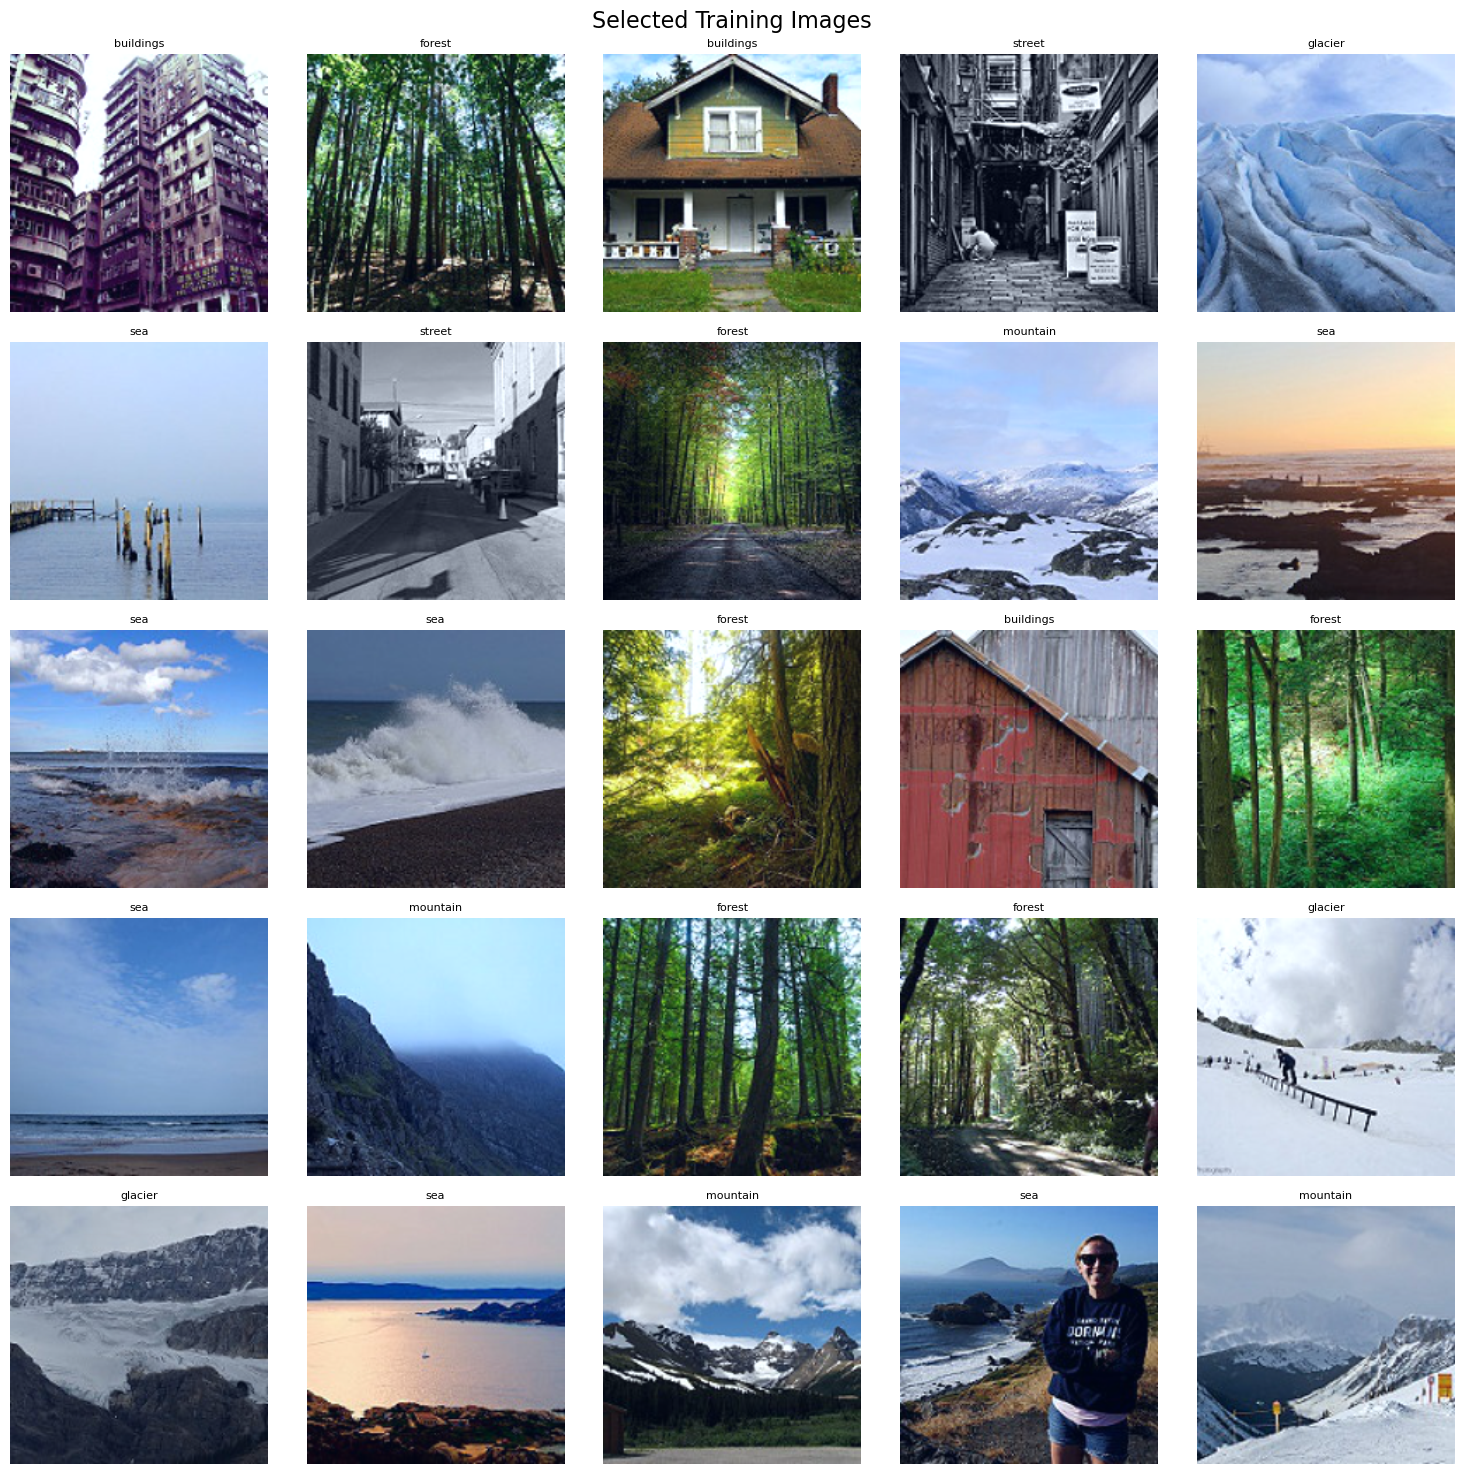

In [14]:
dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_train/seg_train/"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ViT
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet standard normalization
]))

train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create a dense grid of selected training images
num_train_images = 25
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

for i in range(num_train_images):
    image, label = train_dataset[i]
    image = image.cpu().numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    image = (image * 0.229 + 0.485)  # Reverse the normalization
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(full_dataset.classes[label], fontsize=8)

plt.tight_layout()
plt.suptitle('Selected Training Images', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

/cluster/home/thohau/.conda/envs/AI/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/thohau/.conda/envs/AI/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1779690/2700471746.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_on

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

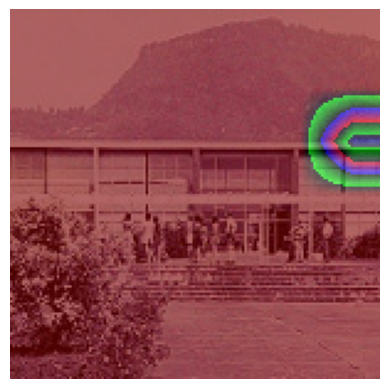

In [12]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load the pretrained model (ResNet50)
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 6)  # Modify the final layer for 6 output classes

# Load the saved model state dictionary
model_path = '/cluster/work/thohau/IT3212/assignment_4/thomas/models/resnet_it3212_gr25.pth'
state_dict = torch.load(model_path)

# Load the state dict into the model
model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore the mismatch in fc layer

# Switch the model to evaluation mode
model.eval()

print(model)

# Print size of the model in MB
model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert bytes to MB
print(f"Model size: {model_size:.2f} MB")

# Count the number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Load and preprocess the image
image_path = '/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_test/seg_test/buildings/20611.jpg'
image = Image.open(image_path).convert('RGB')  # Convert to RGB if not already

# Define the transformation pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image
    transforms.CenterCrop(224),  # Crop it to 224x224
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Move the input tensor to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)
model = model.to(device)

# Hook function to capture feature maps
def hook_fn(module, input, output):
    global feature_map  # Use global variable to store feature map
    feature_map = output[0].detach().cpu()

# Register the hook on a convolutional layer (last convolutional layer in ResNet)
layer = model.layer4[2].conv3  # Last convolutional layer in ResNet50
hook = layer.register_forward_hook(hook_fn)

# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Remove the hook after inference
hook.remove()

# Get predicted class index
_, predicted_class = torch.max(output, 1)
print(f"Predicted class: {predicted_class.item()}")

# Get the average of the feature map across channels (spatial attention)
activation = feature_map.mean(dim=0).numpy()

# Normalize the activation map to 0-1 for visualization
activation = np.maximum(activation, 0)
activation = cv2.resize(activation, (image.width, image.height))
activation -= activation.min()
activation /= activation.max()

# Convert to a heatmap (color map)
heatmap = cv2.applyColorMap((activation * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Convert the original image to RGB for overlay
original_image = np.array(image.convert("RGB"))

# Normalize the heatmap to the same range (0-255)
heatmap = np.uint8(255 * heatmap)

# Overlay the heatmap on the original image
# Use alpha blending to combine the heatmap and the original image
alpha = 0.6  # Control the transparency of the heatmap
overlay = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)

# Show the image with the overlay
plt.imshow(overlay)
plt.axis('off')  # Turn off axis
plt.show()


In [15]:
print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Memory reserved: {torch.cuda.memory_reserved()} bytes")

# Perform memory cleanup
torch.cuda.empty_cache()

print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Memory reserved: {torch.cuda.memory_reserved()} bytes")

Memory allocated: 1405563392 bytes
Memory reserved: 13149143040 bytes
Memory allocated: 1405563392 bytes
Memory reserved: 2472542208 bytes
